In [1]:
import json
import os
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/metrics.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def import_all_metrics_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/metrics.json`, returning a dictionary that maps
    `{run_num}` to the metrics dictionary.
    """
    all_metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_metrics = {key : val for key, val in all_metrics.items() if val}  # Remove empties
    return all_metrics

In [4]:
def import_config_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/config.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "config.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [5]:
def import_all_config_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/config.json`, returning a dictionary that maps
    `{run_num}` to the config dictionary.
    """
    all_config = {run_num : import_config_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_config = {key : val for key, val in all_config.items() if val}  # Remove empties
    return all_config

In [6]:
def extract_metrics_values(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key.
    """
    return metrics[key]["values"]

In [7]:
def extract_metrics_values_at_best_val(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key, but only for
    the epoch that yielded the minimal validation loss. It is assumed that
    the requested key is saved once per epoch.
    """
    best_epoch = np.argmin(extract_metrics_values(metrics, "val_epoch_loss"))
    return extract_metrics_values(metrics, key)[best_epoch]

In [8]:
def smooth_signal(signal, sigma, axis=-1):
    """
    Smooths a signal along the given axis using a Gaussian weight vector.
    Smooths to 1 sigma (unless sigma is 0, and then it does no smoothing).
    """
    if sigma == 0:
        return scipy.ndimage.gaussian_filter1d(signal, 1, axis=axis, truncate=0)
    else:
        return scipy.ndimage.gaussian_filter1d(signal, sigma, axis=axis, truncate=1)

In [40]:
noprior_models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/HepG2_keep1/"
noprior_metrics = import_all_metrics_json(noprior_models_path)
noprior_config = import_all_config_json(noprior_models_path)

In [41]:
prior_models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/HepG2_prior_keep1/"
prior_metrics = import_all_metrics_json(prior_models_path)
prior_config = import_all_config_json(prior_models_path)

Text(0.5, 0, 'Epoch')

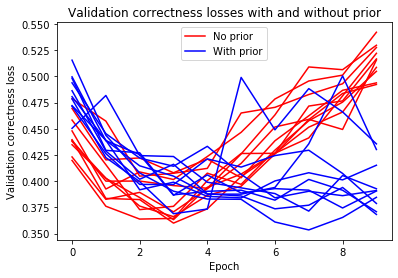

In [42]:
# Plot validation correctness losses with and without prior
noprior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in noprior_metrics.items()}
prior_val_corr_losses = {key : extract_metrics_values(m, "val_corr_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, corr_losses in noprior_val_corr_losses.items():
    line = np.nanmean(corr_losses, axis=1)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_val_corr_losses.items():
    line = np.nanmean(corr_losses, axis=1)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["No prior", "With prior"])
plt.title("Validation correctness losses with and without prior")
plt.ylabel("Validation correctness loss")
plt.xlabel("Epoch")

In [ ]:
# Plot validation profile losses with and without prior
noprior_val_prof_corr_losses = {key : extract_metrics_values(m, "val_prof_corr_losses") for key, m in noprior_metrics.items()}
prior_val_prof_corr_losses = {key : extract_metrics_values(m, "val_prof_corr_losses") for key, m in prior_metrics.items()}
plt.figure()
for key, prof_corr_losses in noprior_val_prof_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(prof_corr_losses, axis=1)), 3)
    noprior_line, = plt.plot(line, color="red")
for key, prof_corr_losses in prior_val_prof_corr_losses.items():
    line = smooth_signal(np.log(np.nanmean(prof_corr_losses, axis=1)), 3)
    prior_line, = plt.plot(line, color="blue")
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Validation profile correctness losses with and without prior")

Text(0.5, 1.0, 'Training correctness losses with and without prior, first 100 batches of epoch 1')

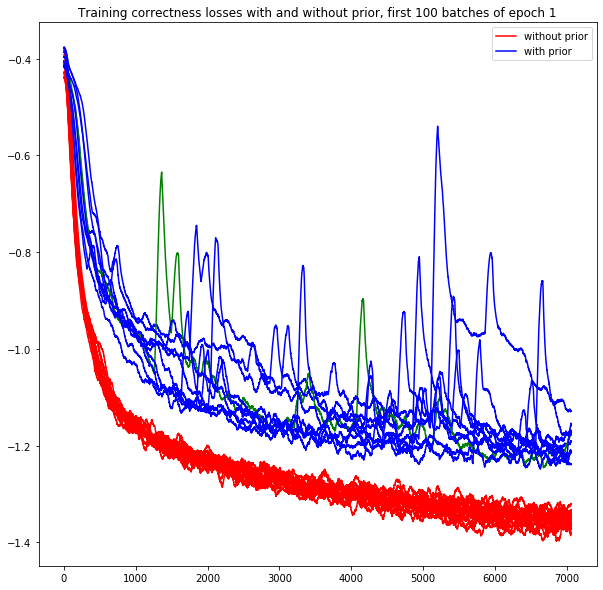

In [15]:
# Plot training correctness losses with and without prior
noprior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in noprior_metrics.items()}
prior_train_corr_losses = {key : extract_metrics_values(m, "train_corr_losses") for key, m in prior_metrics.items()}
plt.figure(figsize=(10, 10))
for key, corr_losses in noprior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:10000]), 50)
    noprior_line, = plt.plot(line, color="red")
for key, corr_losses in prior_train_corr_losses.items():
    line = smooth_signal(np.log(corr_losses[0][:10000]), 50)
    prior_line, = plt.plot(line, color=("green" if key == "3" else "blue"))
plt.legend([noprior_line, prior_line], ["without prior", "with prior"])
plt.title("Training correctness losses with and without prior, first 100 batches of epoch 1")